In [1]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Example script to train the DNC on a repeated copy task."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import datetime
import tensorflow as tf

from dnc import dnc, access
from dnc import repeat_copy

from collections import namedtuple

flags_dict = {
    # Model parameters
    "hidden_size": 64, # Size of LSTM hidden layer.
    "memory_size": 16, # The number of memory slots.
    "word_size": 16, #"The width of each memory slot."
    "num_write_heads": 1, #"Number of memory write heads."
    "num_read_heads": 4, #"Number of memory read heads."
    "clip_value": 20,#"Maximum absolute value of controller and dnc outputs."

    # Optimizer parameters.
    "max_grad_norm": 50, #"Gradient clipping norm limit."
    "learning_rate": 1e-4, #"Optimizer learning rate."
    "optimizer_epsilon": 1e-10, #"Epsilon used for RMSProp optimizer."

    # Task parameters
    "batch_size": 16, #"Batch size for training."
    "num_bits": 4, #"Dimensionality of each vector to copy"
    "min_length": 1,#"Lower limit on number of vectors in the observation pattern to copy"
    "max_length": 2,#"Upper limit on number of vectors in the observation pattern to copy"
    "min_repeats": 1,#"Lower limit on number of copy repeats."
    "max_repeats": 2, #"Upper limit on number of copy repeats."

    "checkpoint_dir": "./checkpoints/repeat_copy", #"Checkpointing directory."
}

flags_schema = namedtuple('flags_schema', list(flags_dict.keys()))
FLAGS = flags_schema(**flags_dict)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [14]:
def load_model():
  """Trains the DNC and periodically reports the loss."""
  access_config = {
      "memory_size": FLAGS.memory_size,
      "word_size": FLAGS.word_size,
      "num_reads": FLAGS.num_read_heads,
      "num_writes": FLAGS.num_write_heads,
  }
  controller_config = {
      #"hidden_size": FLAGS.hidden_size,
    "units": FLAGS.hidden_size,
  }
  clip_value = FLAGS.clip_value

  dnc_cell = dnc.DNC(
    access_config, controller_config, dataset.target_size, FLAGS.batch_size, clip_value)
  dnc_core = tf.keras.layers.RNN(
    cell=dnc_cell,
    time_major=True,
    return_sequences=True,
    return_state=True,
  )
  optimizer = tf.compat.v1.train.RMSPropOptimizer(
      FLAGS.learning_rate, epsilon=FLAGS.optimizer_epsilon)

  # Set up model checkpointing
  checkpoint = tf.train.Checkpoint(model=dnc_core, optimizer=optimizer)
  manager = tf.train.CheckpointManager(checkpoint, FLAGS.checkpoint_dir, max_to_keep=10)

  checkpoint.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")
  return dnc_core


def get_inputs(x, num_reps):
  if len(x[0]) > FLAGS.num_bits:
    print(f"Max input sequence length is {FLAGS.num_bits}")
    return
  sub_seq_len = len(x)
  num_bits = FLAGS.num_bits
  
  # We reserve one dimension for the num-repeats and one for the start-marker.
  full_obs_size = num_bits + 2
  start_end_flag_idx = full_obs_size - 2
  num_repeats_channel_idx = full_obs_size - 1
  
  obs_pattern = tf.cast(x, tf.float32)
  obs_flag_channel_pad = tf.zeros([sub_seq_len, 2])
  obs_start_flag = tf.one_hot(
          [start_end_flag_idx], full_obs_size, on_value=1., off_value=0.)
  num_reps_flag = tf.one_hot(
          [num_repeats_channel_idx],
          full_obs_size,
          on_value=tf.cast(num_reps / 10.0, tf.float32),
          off_value=0.)
  # note the concatenation dimensions.
  obs = tf.concat([obs_pattern, obs_flag_channel_pad], 1)
  obs = tf.concat([obs_start_flag, obs], 0)
  obs = tf.concat([obs, num_reps_flag], 0)
  # add padding
  obs = tf.concat([
    obs,
    tf.zeros((sub_seq_len * num_reps + 1, full_obs_size))
  ], 0)
  obs = tf.reshape(obs, [sub_seq_len * (num_reps + 1) + 3, 1, full_obs_size])
  return obs

dataset = repeat_copy.RepeatCopy(FLAGS.num_bits, FLAGS.batch_size,
                                   FLAGS.min_length, FLAGS.max_length,
                                   FLAGS.min_repeats, FLAGS.max_repeats,
                                   dtype=tf.float32)
dataset_tensor = dataset()

dnc_core = load_model()

x = get_inputs([[1,1,1,1]], 2)
x

Restored from ./checkpoints/repeat_copy/ckpt-90045


<tf.Tensor: shape=(6, 1, 6), dtype=float32, numpy=
array([[[0. , 0. , 0. , 0. , 1. , 0. ]],

       [[1. , 1. , 1. , 1. , 0. , 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0.2]],

       [[0. , 0. , 0. , 0. , 0. , 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. ]]], dtype=float32)>

In [3]:
def read_weights_from_dnc_state(dnc_state):
    return dnc_state[dnc.ACCESS_STATE][access.READ_WEIGHTS]
def write_weights_from_dnc_state(dnc_state):
    return dnc_state[dnc.ACCESS_STATE][access.WRITE_WEIGHTS]
def memory_from_dnc_state(dnc_state):
    return dnc_state[dnc.ACCESS_STATE][access.MEMORY]


In [4]:
for i in x:
    print(i)

tf.Tensor([[0. 0. 0. 0. 1. 0.]], shape=(1, 6), dtype=float32)
tf.Tensor([[1. 1. 1. 1. 0. 0.]], shape=(1, 6), dtype=float32)
tf.Tensor([[0.  0.  0.  0.  0.  0.2]], shape=(1, 6), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0.]], shape=(1, 6), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0.]], shape=(1, 6), dtype=float32)
tf.Tensor([[0. 0. 0. 0. 0. 0.]], shape=(1, 6), dtype=float32)


In [5]:
def evaluate_model(
    x,
    mask,
    rnn_model,
):
    output_sequence = []
    output_states = []
    input_state = rnn_model.get_initial_state(inputs=x)
    for input_seq in x:
        #print(tf.expand_dims(input_seq, axis=0))
        #print(input_state)
        output = rnn_model(
            inputs=tf.expand_dims(input_seq, axis=0),
            initial_state=input_state,
        )
        output_sequence.append(tf.round(tf.sigmoid(output[0])))
        input_state = output[1:]
        output_states.append(input_state)
    return output_sequence, output_states

get_outputs = lambda x: evaluate_model(x, None, dnc_core)


In [7]:
y = get_outputs(x)

In [8]:
y[0]

[<tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=array([[[1., 0., 0., 0., 0.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=array([[[1., 1., 0., 1., 0.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=array([[[1., 1., 0., 1., 0.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=array([[[1., 1., 1., 1., 0.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=array([[[1., 1., 1., 1., 0.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 5), dtype=float32, numpy=array([[[1., 1., 1., 1., 0.]]], dtype=float32)>]

In [9]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np

def visualize_states(states):
    memory = [memory_from_dnc_state(state)[0] for state in states]
    read_weights = [tf.transpose(read_weights_from_dnc_state(state)[0]) for state in states]
    write_weights = [tf.transpose(write_weights_from_dnc_state(state)[0]) for state in states]
    
    memory_color_range = {
        'vmin': np.min(memory),
        'vmax': np.max(memory)
    }
    read_weights_color_range = {
        'vmin': np.min(read_weights),
        'vmax': np.max(read_weights),
    }
    write_weights_color_range = {
        'vmin': np.min(write_weights),
        'vmax': np.max(write_weights),
    }

    for i in range(len(states)):
        print(f'Timestep {i}')
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,5))
        ax1.set_title('Memory')
        ax2.set_title('Read Weights')
        ax3.set_title('Write Weights')

        seaborn.heatmap(memory[i], ax=ax1, **memory_color_range)
        seaborn.heatmap(read_weights[i], ax=ax2, **read_weights_color_range)
        seaborn.heatmap(write_weights[i], ax=ax3, **write_weights_color_range)
        plt.show()


In [10]:
def debug_model(x, num_repeats):
    inputs = get_inputs(x, num_repeats)
    print(f"Input Sequence:\n {inputs}")
    output_sequence, states = evaluate_model(inputs, None, dnc_core)
    print("Output Sequence:")
    print("Reading input phase:")
    for i, output in enumerate(output_sequence):
        if i == len(x) + 2:
            print("Ouput printing phase:")
        print(output)
    visualize_states(states)
    return output_sequence, states

Input Sequence:
 [[[0.  0.  0.  0.  1.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[1.  1.  1.  1.  0.  0. ]]

 [[0.  1.  0.  1.  0.  0. ]]

 [[1.  0.  1.  0.  0.  0. ]]

 [[1.  1.  1.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0.3]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0. ]]]


Output Sequence:
Reading input phase:
tf.Tensor([[[1. 0. 0. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[1. 0. 0. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[1. 0. 0. 1. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[1. 0. 0. 1. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[0. 0. 0. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[0. 0. 0. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[0. 0. 0. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
Ouput printing phase:
tf.Tensor([[[1. 1. 1. 1. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[1. 1. 0. 1. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[1. 1. 1. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[0. 0. 0. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[1. 1. 1. 1. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[1. 1. 0. 1. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[1. 1. 1. 0. 0.]]], shape=(1, 1, 5), dtype=float32)
tf.Tensor([[[0. 0. 0. 0. 1.]]], shape=(1, 1,

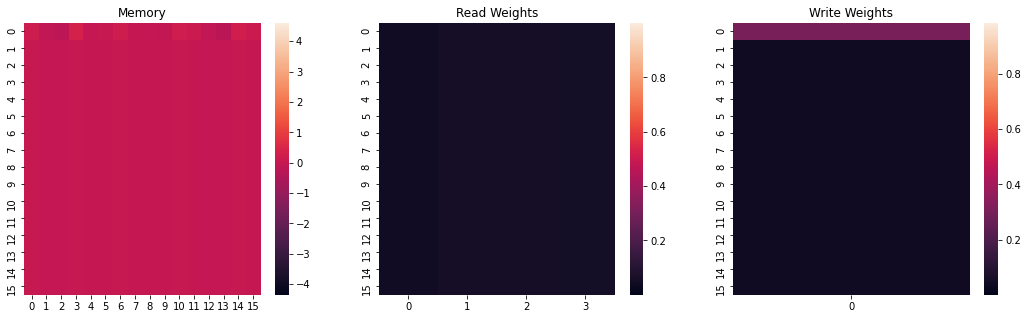

Timestep 1


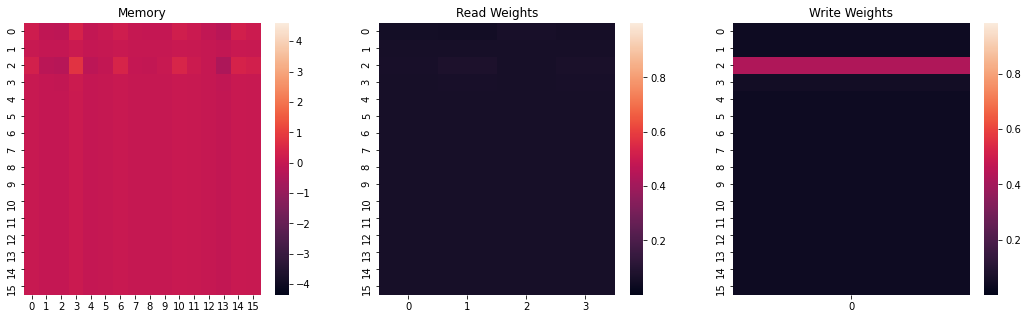

Timestep 2


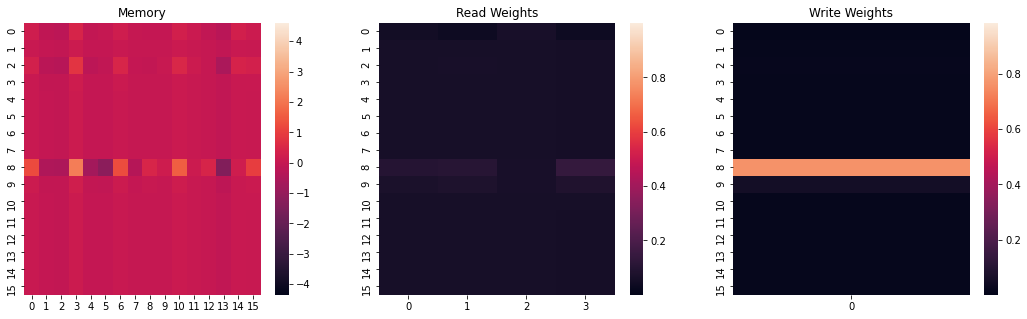

Timestep 3


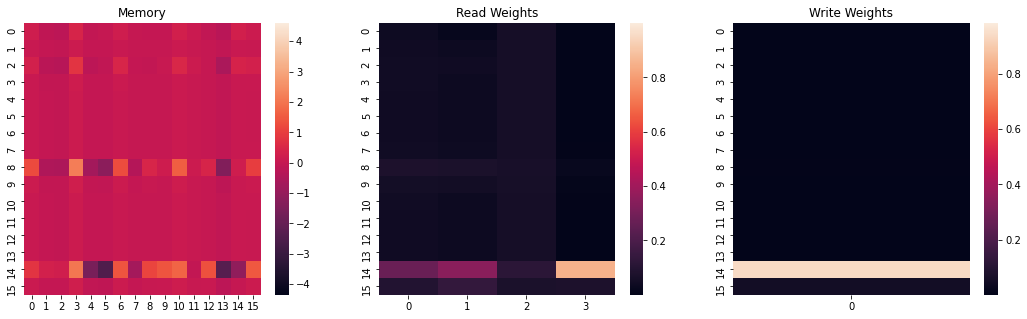

Timestep 4


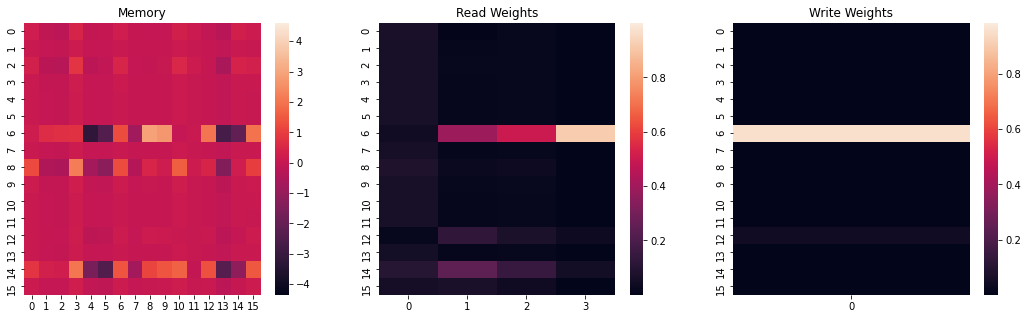

Timestep 5


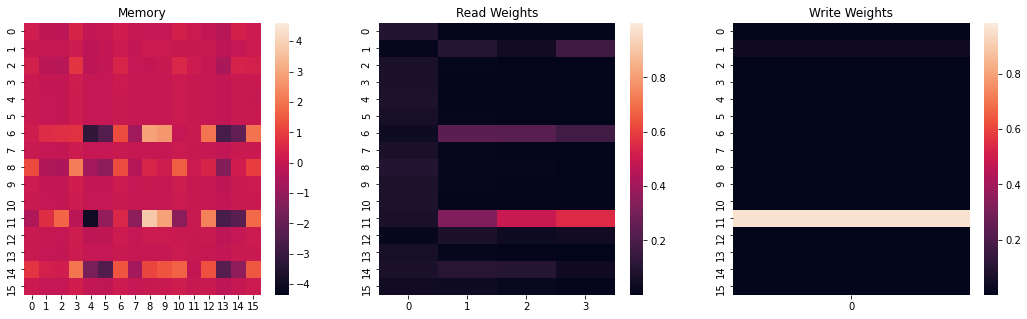

Timestep 6


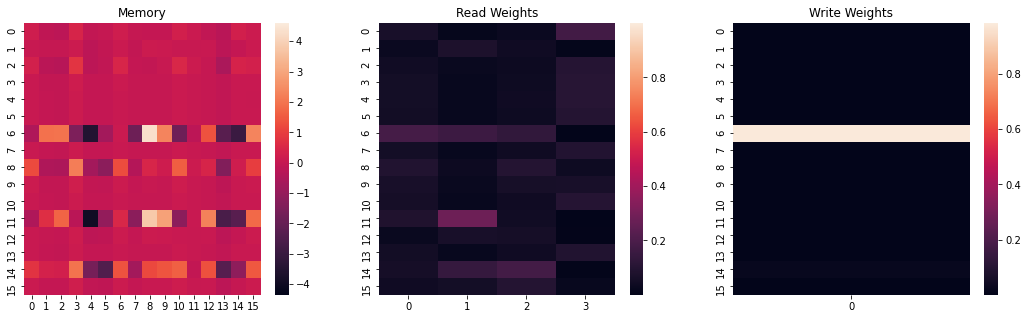

Timestep 7


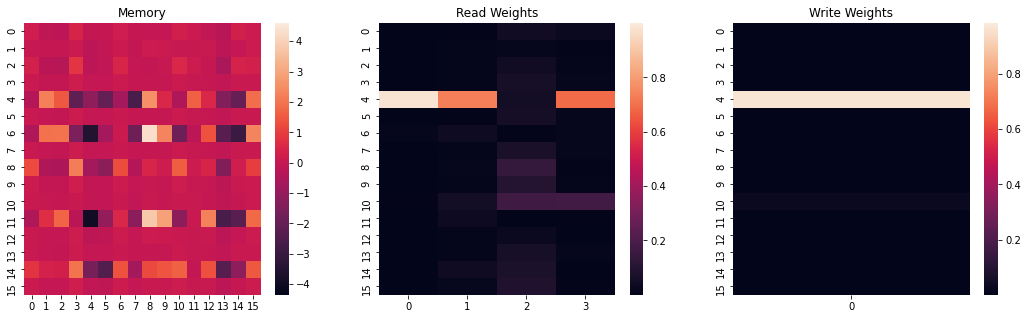

Timestep 8


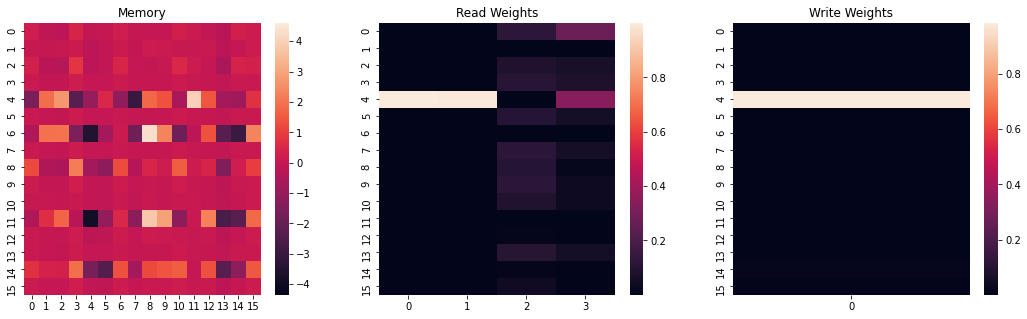

Timestep 9


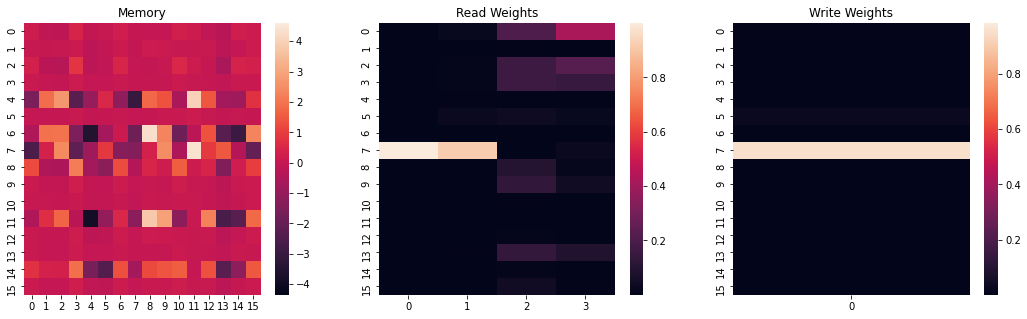

Timestep 10


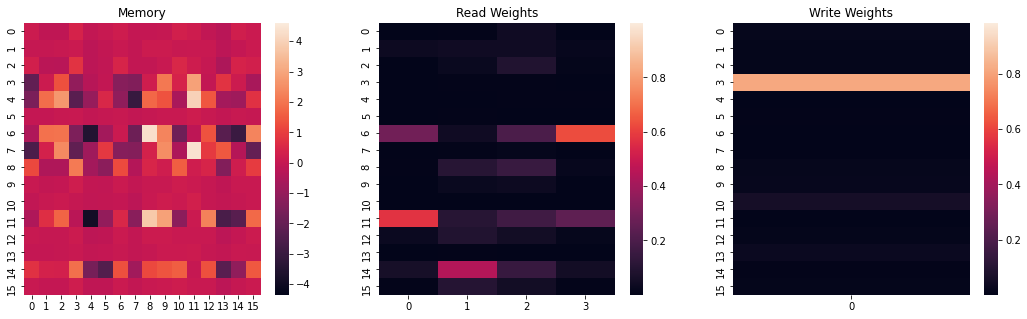

Timestep 11


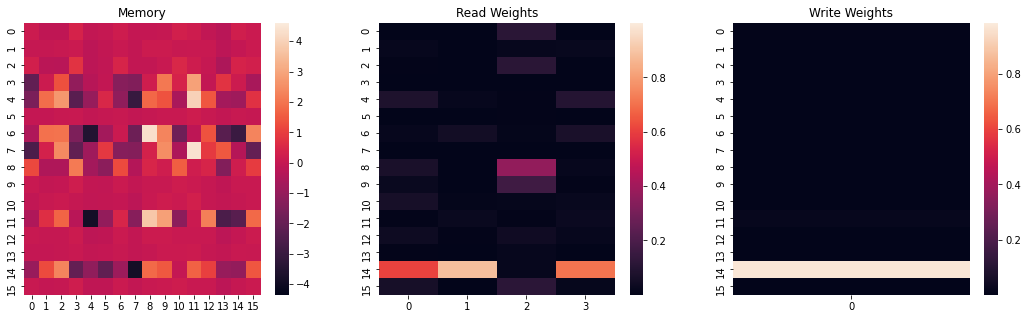

Timestep 12


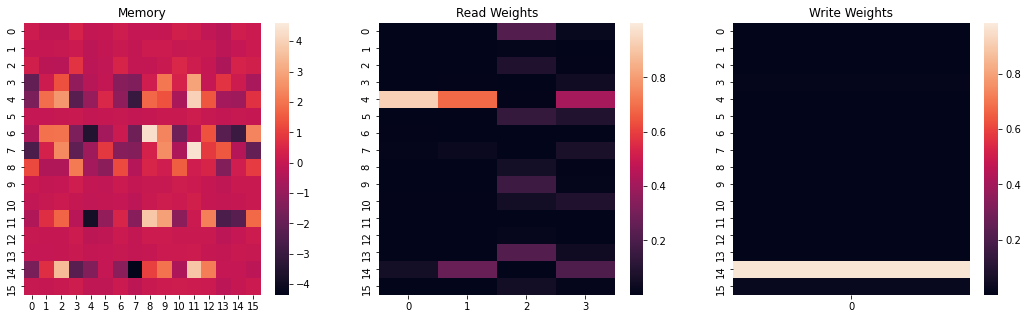

Timestep 13


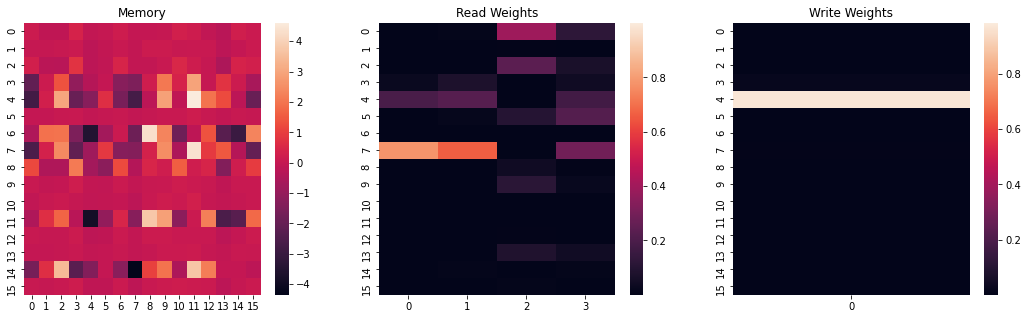

Timestep 14


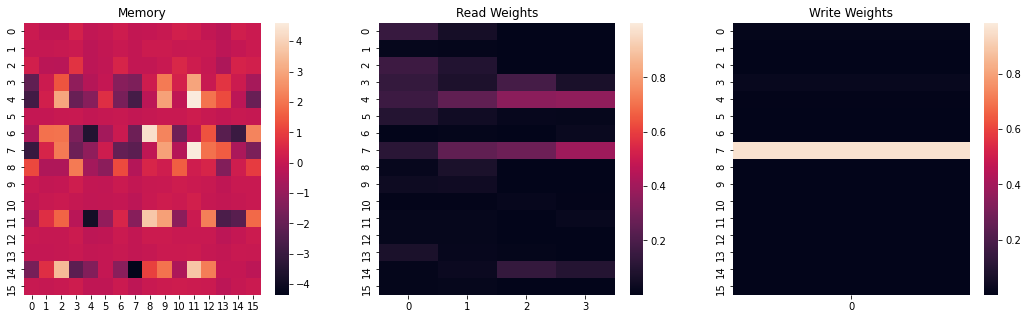

Timestep 15


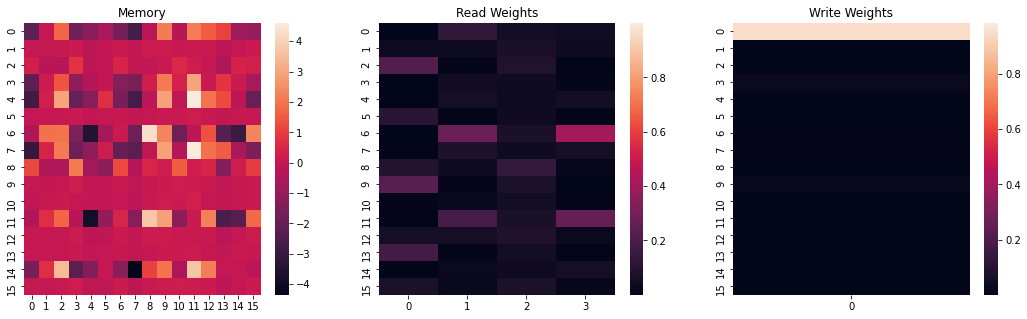

Timestep 16


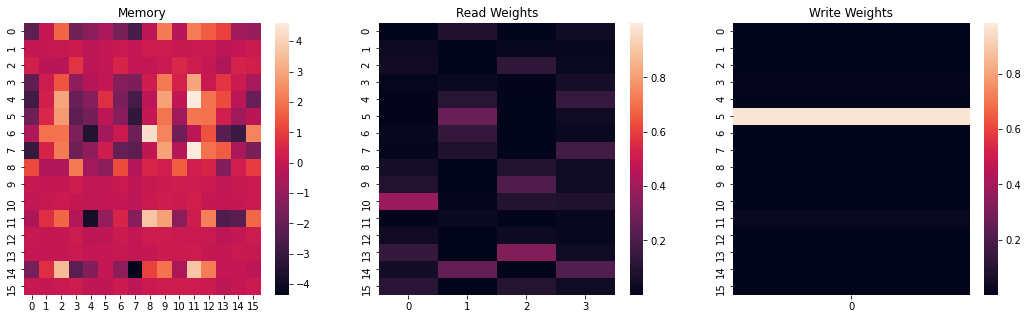

Timestep 17


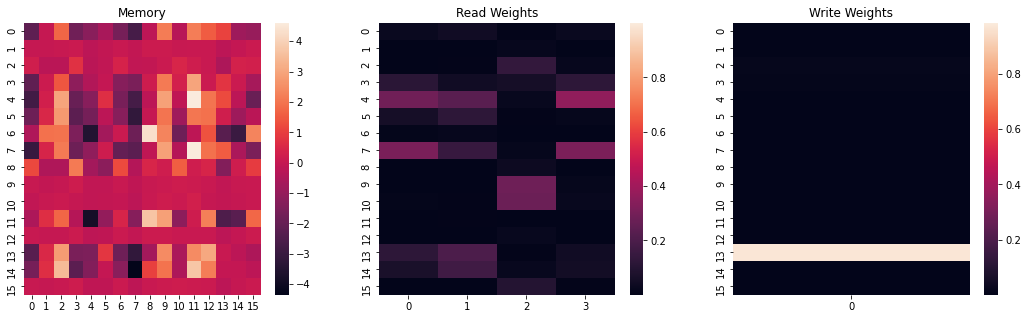

Timestep 18


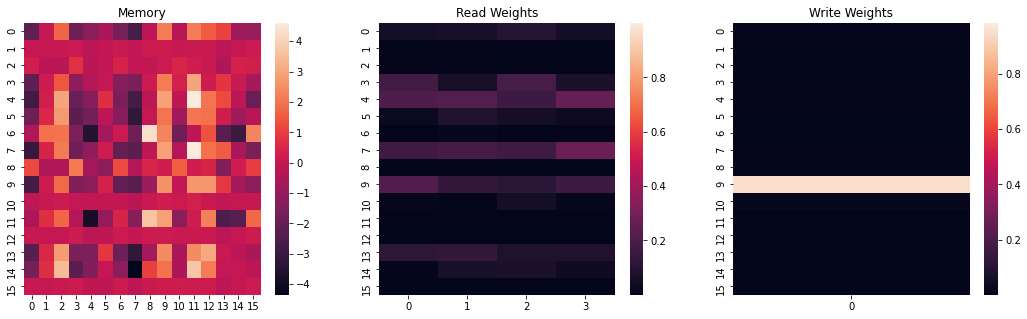

Timestep 19


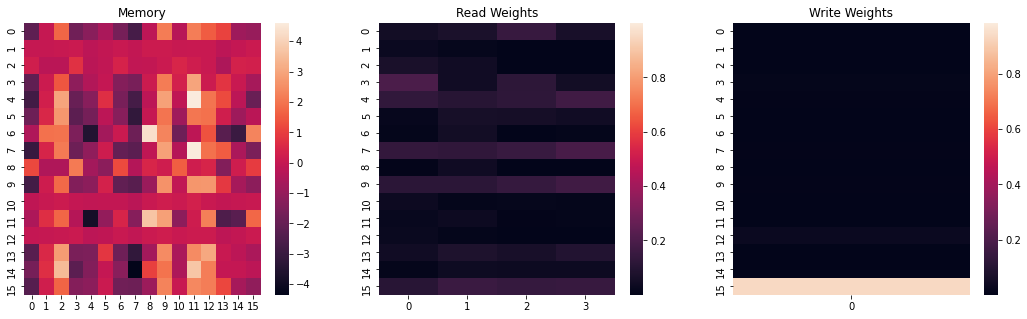

Timestep 20


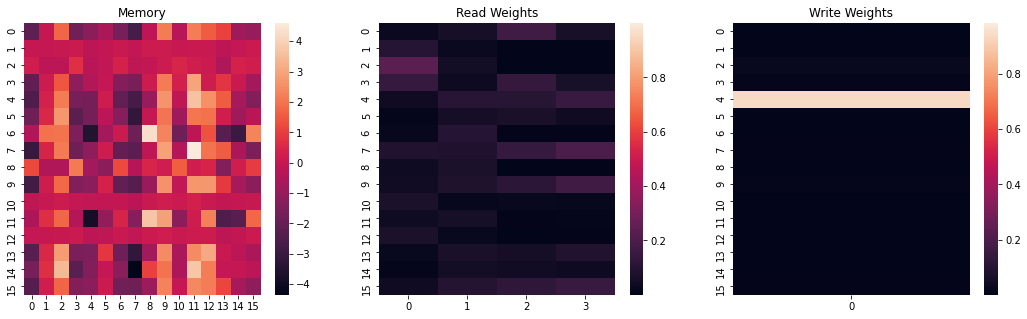

Timestep 21


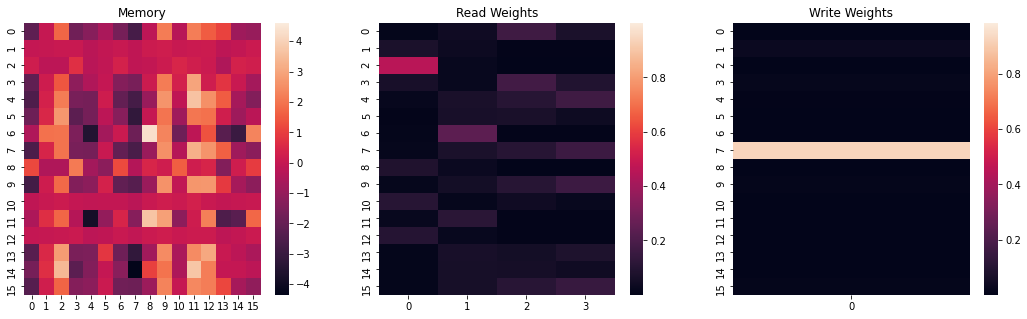

Timestep 22


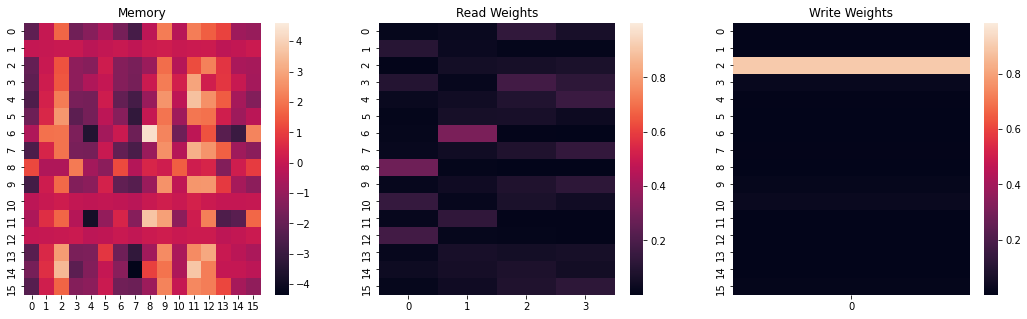

In [15]:
a = debug_model([[0, 0,0,0], [1,1,1,1], [0,1,0,1], [1,0,1,0], [1,1,1,0]], 3)